# Tracking the Evolution of Machine Learning Technology Network using Stack Overflow data

### Table of Contents
##### 1. Preliminary Data Wrangling 
##### 2. Network Construction
##### 3. Preferential Treatment Analysis
##### 4. Temporal Graph Distances

## 1. Preliminary Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import os, json, pickle
from line_profiler import profile as profile
import swifter
import powerlaw
import seaborn as sns
import pylab

data_dir = os.getcwd() + "/overflow_data/"
fdir = os.getcwd() + "/working_data/"
figs_dir = os.getcwd() + "/figures/"

matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11)

/Users/qixuan.khoo.19/mambaforge/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [81]:
# Load and combine all JSON files into a single dataframe

years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

records = []

for year in years: 
    with open(data_dir+'overflow_{}.json'.format(year), 'r') as file:
        data = json.load(file)
    
    for item in data:
        record = item['f0_']
        
        records.append({
            'ID': record['_field_1'],
            'Timestamp': record['_field_2'],
            'Tags': record['_field_3'].lower().split('|'),  # Split the tags into a list
            'Year': year
        })
    
    # Convert the list of dictionaries to a Pandas DataFrame

df = pd.DataFrame(records)
    
# Convert the 'Timestamp' column to a datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 

In [98]:
df2 = df.explode('Tags')
df2 = df2[df2['Tags']!='machine-learning'] # remove the ML tag

tags_freq = df2[['Tags', 'ID']].groupby('Tags').size().sort_values(ascending=False)
tags_freq.name = "Number of Questions"
most_common_tags = df2.merge(tags_freq, how="left", right_on="Tags", left_on="Tags")

N_Questions_All_Time = df.shape[0]
most_common_tags['% Questions Represented'] = most_common_tags['Number of Questions'].apply(lambda x: x / N_Questions_All_Time)

most_common_tags = most_common_tags[['Tags', '% Questions Represented', 'Number of Questions']].drop_duplicates().sort_values(by="% Questions Represented", ascending=False)

# Compute year introduced for each tag
temp = df2[['Tags', 'Year']].groupby('Tags').min().reset_index()
temp.columns = ["Tags", "Year_Introduced"]
most_common_tags = most_common_tags.merge(temp, how="left", left_on="Tags", right_on="Tags").sort_values(by="% Questions Represented", ascending=False)

#### Plot of Tags and Cumulative Frequencies

In [7]:
# Compute the union of all questions represented by most common tags

# Dictionary with key as tag and value as the % of questions represented by the union
# of all tags from the most common to the current tag (the key)
cum_dict = {} 
curr_union = set()

tag_qs = df2[['Tags', 'ID']]

for tag in most_common_tags['Tags']:
    B = set(df2[df2['Tags']==tag]['ID'].to_numpy())
    curr_union = curr_union.union(B)
    cum_dict[tag] = len(curr_union) / N_Questions_All_Time

qwe = pd.DataFrame.from_dict(cum_dict, orient='index').reset_index()
qwe.columns = ['Tags', 'Cum_%_by_Rank']
most_common_tags = most_common_tags.merge(qwe, how="left", left_on="Tags", right_on="Tags")

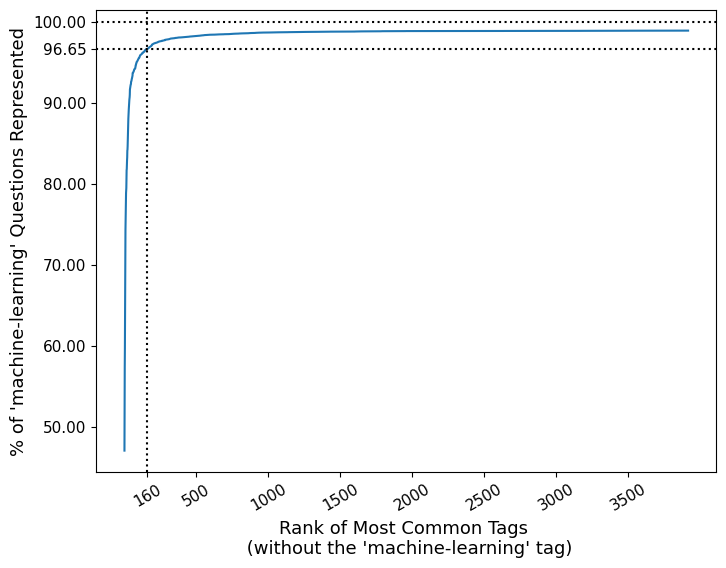

In [8]:
# Cumulative % of Questions Represented by Tags
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot([x + 1 for x in range(0, len(cum_dict))], [ y*100 for y in cum_dict.values() ])
plt.axvline(x=160, color='black', linestyle='dotted')
plt.axhline(y=96.65, color='black', linestyle='dotted')
plt.axhline(y=100, color='black', linestyle='dotted')
x_ticks = [ x for x in range(0, 4500, 500) ]
x_ticks.append(160)
x_ticks.remove(0)
x_ticks.remove(4000)
ax.set_xticks(x_ticks)
plt.xticks(rotation=30)
y_ticks = [y for y in range(50, 110, 10)]
y_ticks.append(96.65)
ax.set_yticks(y_ticks)

plt.ylabel("% of 'machine-learning' Questions Represented", fontsize=13)
plt.xlabel("Rank of Most Common Tags \n (without the 'machine-learning' tag)", fontsize=13)
plt.savefig(figs_dir+"questions_represented.png", bbox_inches='tight')
plt.show()

In [108]:
# Create graph distance sample for temporal distance analysis

# tag_created_year.pkl contains query results on creation date of each tag from Google BigQuery 
with open(fdir+'tag_created_year.pkl', 'rb') as f: 
    t = pickle.load(f)

tag_created = pd.DataFrame.from_dict(t, orient='index')
tag_created.reset_index(inplace=True)
tag_created.columns = ['tag', 'created_year']
# exclude tags introduced after 2012
include_lst = tag_created[tag_created['created_year'] != 0]

include = include_lst.merge(most_common_tags['Tags'][:160], how='left', left_on='tag', right_on='Tags')
include.dropna(inplace=True)
print(f"Of the 160 most common tags, {include.shape[0]} were introduced between 2008-2012")

Of the 160 most common tags, 118 were introduced between 2008-2012


## 2. Network Construction 

In [11]:
# Define helper functions
def compute_lift(tag1, tag2, df, tag_count_dict):
    '''
    Helper function that takes in two Stack Overflow tags, a dataframe and 
    a tag-count dictionary, and compute the association rule learning lift value 
    using co-occurrence probabilities of the tags (see Methods section of the paper)
    '''
    N = df.shape[0]
    temp = df[df['Tags'].swifter.progress_bar(False).apply(lambda x: tag1 in x and tag2 in x)]

    P_tag1 = tag_count_dict[tag1] / N
    P_tag2 = tag_count_dict[tag2] / N
    P_tag1_tag2 =  temp.shape[0] / N

    lift = P_tag1_tag2 / (P_tag1 * P_tag2)

    return lift

def compute_tag_count(df):
    '''
    Helper function that takes in a Stack Overflow questions dataframe and 
    returns a dictionary of every tag and its corresponding number of occurrences
    across all questions in the dataframe
    '''
    tags = df[['Tags', 'ID']].explode('Tags').groupby('Tags').count()
    tag_count = tags.to_dict()['ID']

    return tag_count
    
def construct_network(df):
    '''
    Given a Stack Overflow questions dataframe, returns a networkx 
    graph object representing the network of Stack Overflow technology tags
    '''
    tag_count_dict = compute_tag_count(df)
    tags = [ x for x in tag_count_dict ]
    g = nx.Graph()
    edges = {}

    for i in range(0, len(tags)-1): 
        for j in range(i+1, len(tags)):
            lift = compute_lift(tags[i], tags[j], df, tag_count_dict) 
                
            if lift > 1:
                edges[(tags[i], tags[j])] = lift

    g.add_edges_from(edges.keys())

    for edge in edges:
        g.edges[edge]['weight'] = edges[edge]

    return g

In [97]:
G = {}

years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022']

for year in years:
    data = df[df['Year'] == year] 
    g = construct_network(data, year)
    degrees = dict(g.degree())
    nx.set_node_attributes(g, name='degree', values=degrees)
    G[str(year)] = g

# Create network for the period 2008-2012
lst = [2008, 2009, 2010, 2011, 2012]
data = df[df['Year'].isin(lst)] 
g = construct_network(data)
degrees = dict(g.degree())
nx.set_node_attributes(g, name='degree', values=degrees)

for tag in most_common_tags['Tags']: 
        if tag not in list(g.nodes()):
            g.add_node(tag) 
            
G['2008-12'] = g

with open('Graphs_full.pkl', 'wb') as f:
    pickle.dump(G, f)

In [12]:
with open(fdir+'Graphs_full.pkl', 'rb') as f:
    G = pickle.load(f)

yrs = ['2008-12', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022']

# Create sample 2 for temporal graph distance analysis
G2 = {}
for yr in yrs:
    G2[yr] = G[yr].copy()
    lst = [n for n in df2['Tags'] if n not in list(include['tag'])]
    G2[yr].remove_nodes_from(lst)

with open(fdir+'G_clean.pkl', 'wb') as f:
    pickle.dump(G2, f)

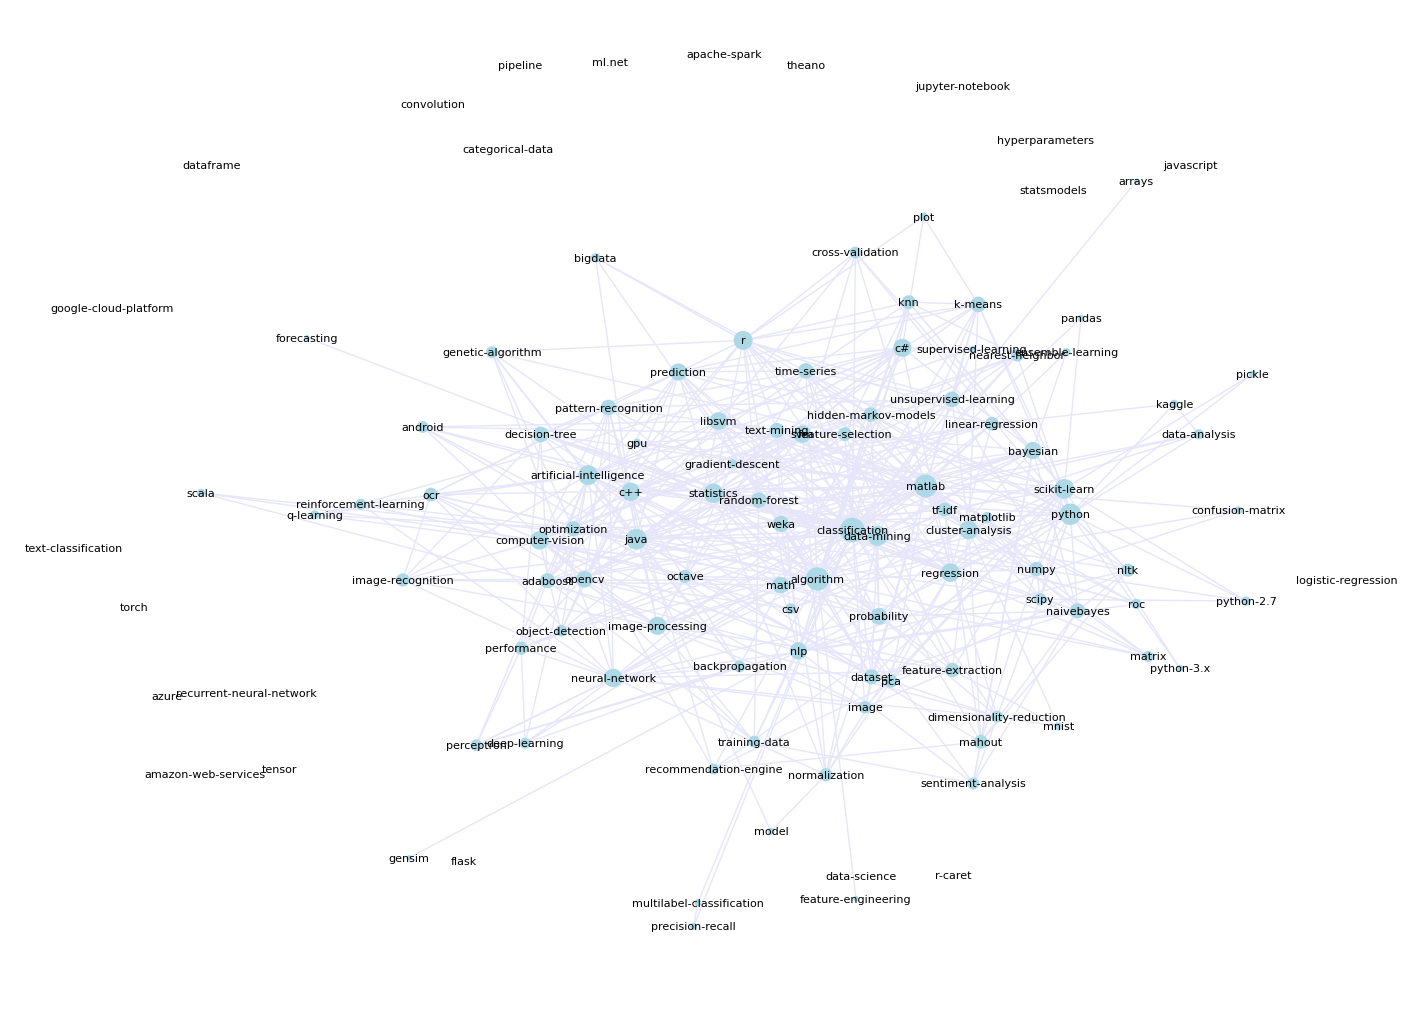

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

with open(fdir+'G_clean.pkl', 'rb') as f:
    G2 = pickle.load(f)

g = G2['2008-12']
g.remove_nodes_from(['tensorflow', 'keras'])
pos = nx.spring_layout(g, scale=20, k=12/np.sqrt(g.order()))
d = dict(g.degree)
nx.draw(g, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*8 for k in d], font_size=8, edge_color=[ 'lavender'for k in d ])

plt.savefig(figs_dir+"network_2008-12.png", bbox_inches='tight')

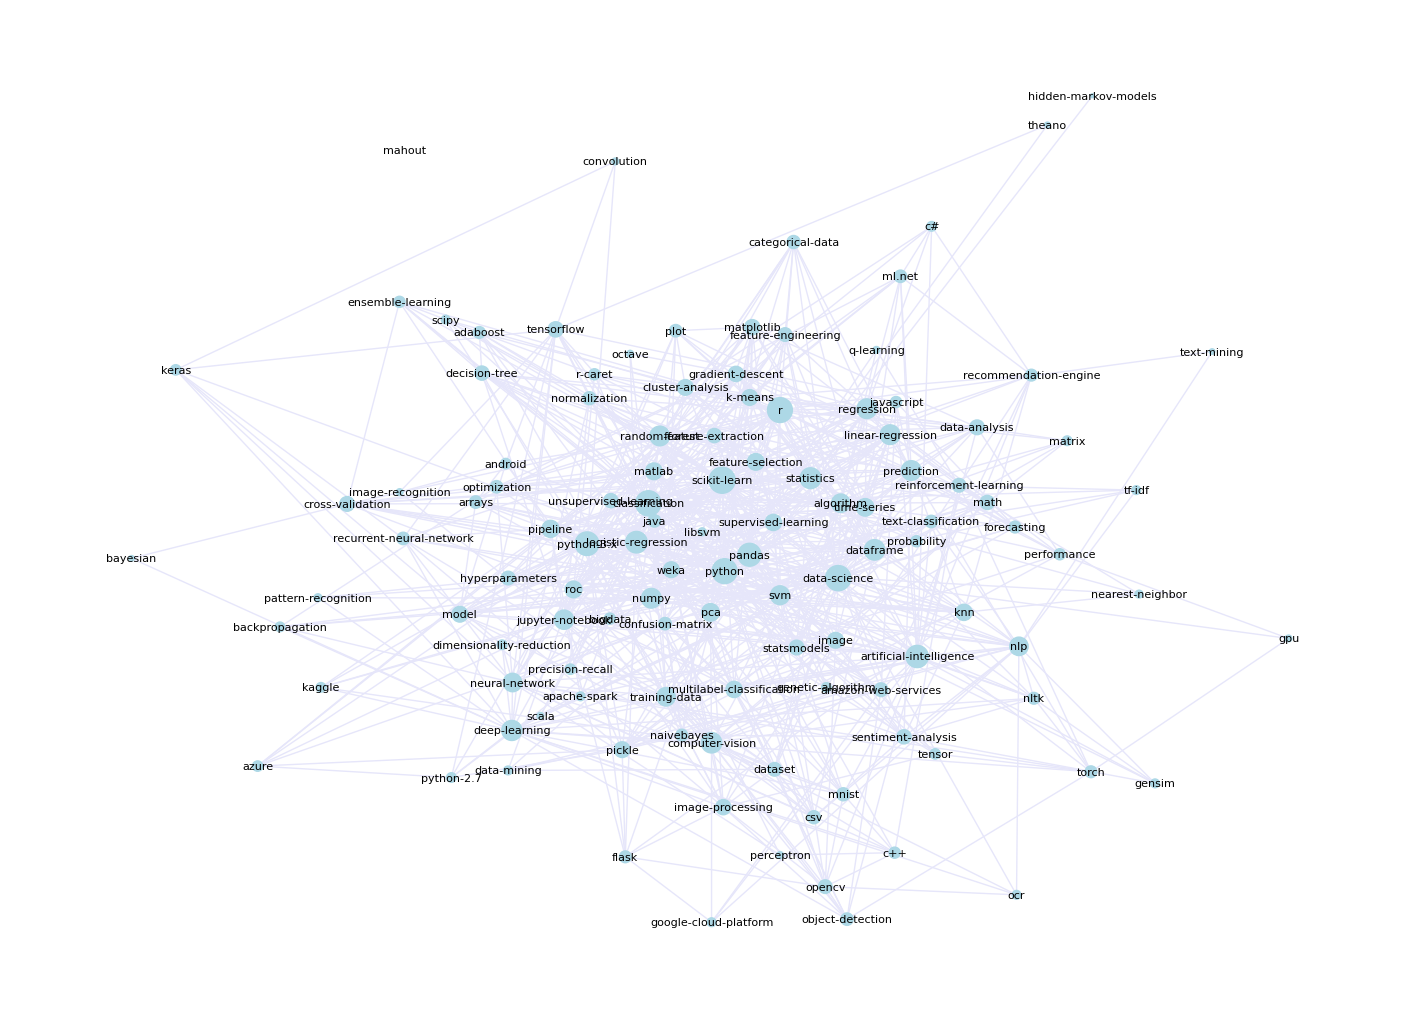

In [6]:
g = G2['2022']
pos = nx.spring_layout(g, scale=20, k=12/np.sqrt(g.order()))
d = dict(g.degree)

d_lst = [ x[1] for x in g.degree() ]
d_lst.sort(reverse=True)

# labels = {
#     n[0]: (n[0] if n[1]  >= d_lst[3]
#         else '')
#     for n in g.degree()
# }

nx.draw(g, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*8 for k in d], font_size=8, edge_color= ['lavender' for n in d_lst], alpha=1)
plt.savefig(figs_dir+"network_2022.png", bbox_inches='tight')

## 3. Preferential Treatment Analysis

### 3.1 Power Law Distribution

In [303]:
# Fit power law distribution to the network by year
power_law_alpha_year = {}
year_alpha = {}
year_p = []

years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
         '2016', '2017', '2018', '2019', '2020', '2021', '2022']

for year in years: 
    g = G[year] 
    degrees = [ d for n, d in g.degree()]
    fit = powerlaw.Fit(degrees)
    a = fit.power_law.alpha
    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    year_alpha[year] = a
    year_p.append(p)

alpha_df = pd.DataFrame.from_dict(year_alpha, orient='index')
alpha_df.columns = ['alpha']
alpha_df['p-value'] = year_p
alpha_df.reset_index(inplace=True)
alpha_df.columns = ['Year', 'Alpha', 'P-value']
#print(alpha_df[['Year', 'Alpha']].to_latex(index=False))

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/qixuan.khoo.19/mambaforge/lib/python3.10/site-packages/powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for powe

,Year,Alpha,P-value
0,2008,10.459908,1.019989e-02
1,2009,3.359158,2.919445e-05
2,2010,2.969544,5.699082e-09
3,2011,2.301117,8.501249e-03
4,2012,2.521036,6.588131e-02
5,2013,2.369702,1.586054e-02
6,2014,2.477249,1.753936e-03
7,2015,2.104747,2.296934e-05
8,2016,2.173260,7.698775e-07
9,2017,2.197633,5.377824e-10


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/qixuan.khoo.19/mambaforge/lib/python3.10/site-packages/powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


alpha: 2.9695444542631835
p-value: 5.699081703909853e-09


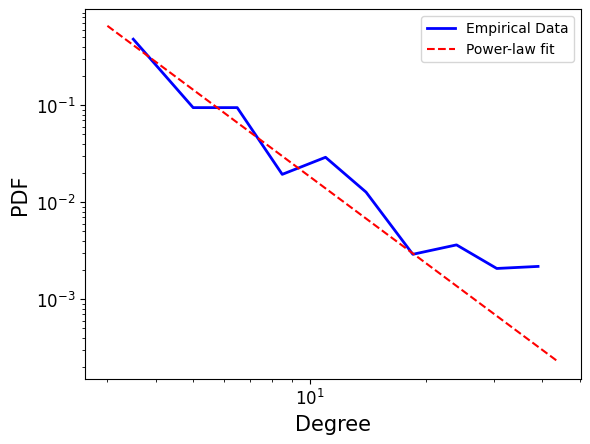

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


alpha: 2.173260097217636
p-value: 7.698775457582601e-07


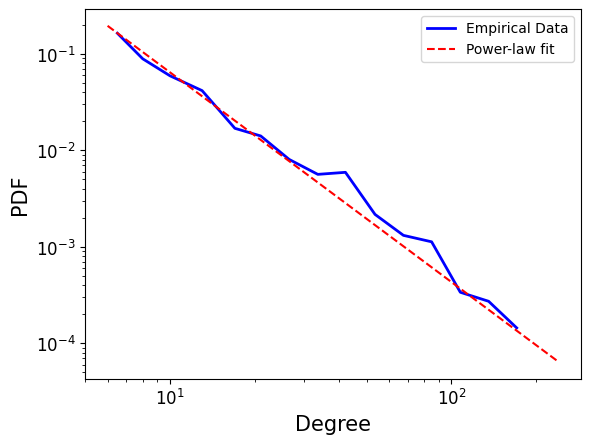

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/qixuan.khoo.19/mambaforge/lib/python3.10/site-packages/powerlaw.py:692: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /


alpha: 2.250081339994836
p-value: 8.451062789026041e-07


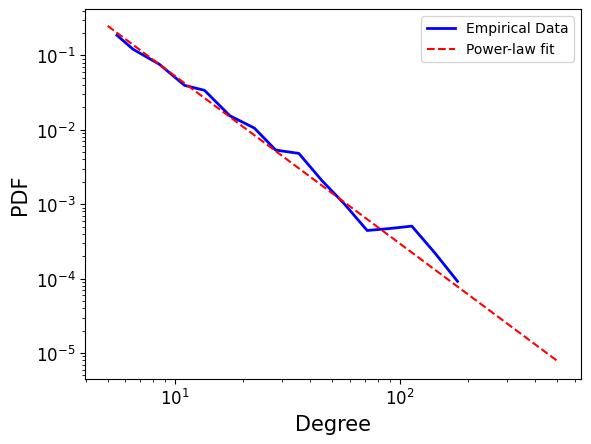

In [344]:
def plot_power_law(data, title='Degree Distribution with Power-law Fit', xlabel='Degree'):
    '''
    Given year and a dictionary with year as key and (a, loc, scale) as the corresponding
    power law distribution parameters, plot the fitted power law distribution for the graph
    '''
    fit = powerlaw.Fit(data)
    
    fig, ax = plt.subplots()
    fit.plot_pdf(color='b', linewidth=2, ax=ax, label='Empirical Data')
    
    fit.power_law.plot_pdf(color='r', linestyle='--', ax=ax, label='Power-law fit')
    
    # Setting the plot to log-log scale
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Adding labels and legend
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel('PDF', fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    #ax.set_title(title)
    ax.legend(fontsize=10)

    R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
    print('alpha: {}'.format(fit.power_law.alpha))
    print('p-value: {}'.format(p))
    plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
    plt.show()

g = G['2010']
data = [d for n, d in g.degree()]
plot_power_law(data, title='Degree Distribution with Power-law Fit (2010)')

g = G['2016']
data = [d for n, d in g.degree()]
plot_power_law(data, title='Degree Distribution with Power-law Fit (2016)')

g = G['2021']
data = [d for n, d in g.degree()]
plot_power_law(data, title='Degree Distribution with Power-law Fit (2021)')

### 3.2 New Node Attachment

In [320]:
# Compute the number of new nodes attached 
years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022']

# Dictionary with year - dictionary of nodes and number of new nodes attached in year t+1 as key-value pair
new_nodes_attached = {}
year_alpha = {}

for i in range(len(years)-1):
    g1 = G[years[i]]    
    g2 = G[years[i+1]]
    new_nodes_attached[years[i+1]] = {}
    
    for node in g1:
        neighbors1 = set(g1.neighbors(node)) if node in g1 else set()
        neighbors2 = set(g2.neighbors(node))
    
        new_neighbors = neighbors2 - neighbors1
        new_nodes_attached[years[i+1]][node] = len(new_neighbors)

### 3.3 Centrality and New Node Attachment

In [ ]:
# Compute centrality measures by year for both samples
years = ['2008', '2009', '2010', '2011', '2012','2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022', '2008-12']

Degree = {}
Close = {}
Between = {}

Degree2 = {}
Close2 = {}
Between2 = {}

#Pre-compute all centrality measures for all years for multiple analyses
for year in years:
    if year in G2:
        g = G2[year]
        Degree2[year] = nx.degree_centrality(g)
        Close2[year] = nx.closeness_centrality(g)
        Between2[year] = nx.betweenness_centrality(g, normalized=True)
    
    g = G[year]    
    Degree[year] = nx.degree_centrality(g)
    Close[year] = nx.closeness_centrality(g)
    Between[year] = nx.betweenness_centrality(g, normalized=True)

d = {}
d['Degree'] = Degree
d['Close'] = Close
d['Between'] = Between

d2 = {}
d2['Degree'] = Degree2
d2['Close'] = Close2
d2['Between'] = Between2

with open(fdir+'centralities_dict.pkl', 'wb') as f:
    pickle.dump(d,f)

with open(fdir+'centralities_dict2.pkl', 'wb') as f:
    pickle.dump(d2,f)

In [359]:
# Correlation analysis between # of new nodes in t+1 and centrality in t
with open(fdir+'centralities_dict.pkl', 'rb') as f:
    centralities = pickle.load(f)
    Degree = centralities['Degree']
    Between = centralities['Between']
    Close = centralities['Close']
    
B = []
D = []
C = []


from scipy.stats import pearsonr

yrs = ['2008', '2009', '2010', '2011', '2012','2013', '2014', '2015', 
       '2016', '2017', '2018', '2019', '2020', '2021', '2022']

for i in range(len(yrs)-1):
    t0 = yrs[i]
    t1 = yrs[i+1]
    
    new_nodes = [ new_nodes_attached[t1][n] for n in G[t0].nodes() ]
    degree_c = [ Degree[t0][n] for n in G[t0].nodes() ]
    close_c = [ Close[t0][n] for n in G[t0].nodes() ]
    between_c = [ Between[t0][n] for n in G[t0].nodes() ]
    
    B.append(round(pearsonr(between_c, new_nodes)[0], 2))
    C.append(round(pearsonr(degree_c, new_nodes)[0], 2))
    D.append(round(pearsonr(close_c, new_nodes)[0], 2))

d = { 'Year': yrs[:-1], 'Betweenness': B, 'Closeness': C, 'Degree': D }
df_corr = pd.DataFrame.from_dict(d, orient='index').T.set_index('Year')
# print(df_corr.applymap(lambda x: str.format("{:0_.2f}", x)).T.to_latex(index=True))

\begin{tabular}{lllllllllllllll}
\toprule
Year & 2008 & 2009 & 2010 & 2011 & 2012 & 2013 & 2014 & 2015 & 2016 & 2017 & 2018 & 2019 & 2020 & 2021 \\
\midrule
Betweenness & 0.45 & 0.73 & 0.77 & 0.81 & 0.82 & 0.85 & 0.78 & 0.83 & 0.86 & 0.86 & 0.87 & 0.89 & 0.90 & 0.86 \\
Closeness & 0.52 & 0.78 & 0.81 & 0.87 & 0.89 & 0.91 & 0.87 & 0.90 & 0.90 & 0.93 & 0.94 & 0.95 & 0.95 & 0.95 \\
Degree & 0.52 & 0.54 & 0.49 & 0.51 & 0.47 & 0.48 & 0.49 & 0.45 & 0.38 & 0.33 & 0.34 & 0.33 & 0.28 & 0.29 \\
\bottomrule
\end{tabular}



## 4. Temporal Graph Distances

### 4.1 Structural and Mesoscopic (Connectivity-based) Graph Distances

In [118]:
with open(fdir+'G_clean.pkl', 'rb') as f:
    G2 = pickle.load(f)

with open(fdir+'centralities_dict2.pkl', 'rb') as f:
    d = pickle.load(f)
    Degree = d['Degree']
    Close = d['Close']
    Between = d['Between']

def centrality_dist(t1, t2, type='degree'):
    '''
    Given periods t1, t2, centrality metric and a global variable G with all graphs,
    returns the dissimilarity matrix D, using pre-computed centrality values
    '''
    if type == 'betweenness':
        C1 = Between[t1]
        C2 = Between[t2]
    elif type == 'closeness':
        C1 = Close[t1]
        C2 = Close[t2]
    else:
        C1 = Degree[t1]
        C2 = Degree[t2]

    c1 = [ c for n, c in C1.items() ]
    c2 = [ c for n, c in C2.items() ]
    d = np.linalg.norm(np.subtract(c1, c2))
    
    return d

def jaccard_dist(t1, t2):
    g1 = G2[t1]
    g2 = G2[t2]
    
    edges1 = {frozenset(edge) for edge in g1.edges()}
    edges2 = {frozenset(edge) for edge in g2.edges()}
    
    intersection = edges1.intersection(edges2)
    union = edges1.union(edges2)
    
    # The Jaccard distance is one minus the ratio of the sizes of intersection to union
    return 1 - len(intersection) / len(union)

def hamming_dist(t1, t2):
    g1 = G2[t1]
    g2 = G2[t2]
    N = g1.number_of_nodes()

    edges1 = {frozenset(edge) for edge in g1.edges()}
    edges2 = {frozenset(edge) for edge in g2.edges()}

    return len(edges2 - edges1) / (N * (N-1))

def dissimilarity_matrix(years, type='degree'):
    '''
    Given years list, plot the heatmap of dissimilarity distances between graphs
    '''
    N = len(years)

    D = [ [ 0 for i in range(N) ] for i in range(N) ]

    for i in range(N):
        for j in range(i+1, N):
            if type == 'jaccard':
                d = jaccard_dist(years[i], years[j])
            elif type == 'hamming':
                d = hamming_dist(years[i], years[j])
            else:
                d = centrality_dist(years[i], years[j], type=type)
                
            D[i][j] = d
            D[j][i] = d
    
    return D

Heatmap of Dissimilarity Distances (Degree Centrality)


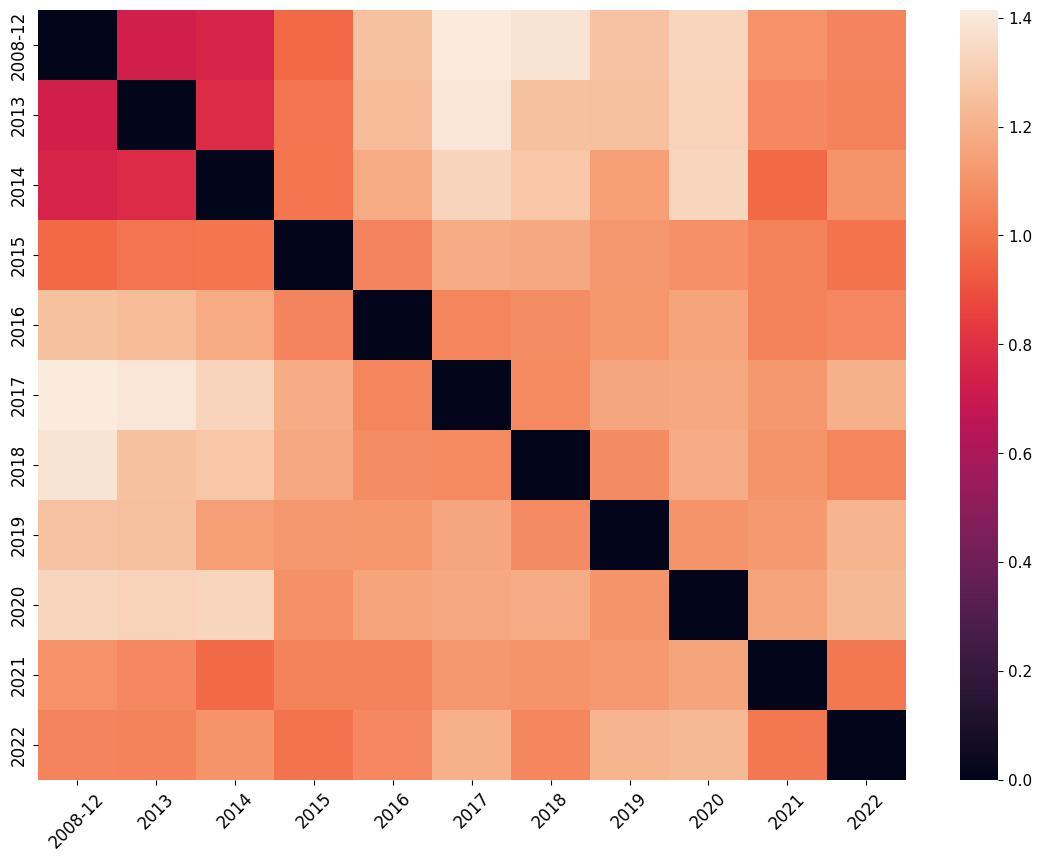

Heatmap of Dissimilarity Distances (Closeness Centrality)


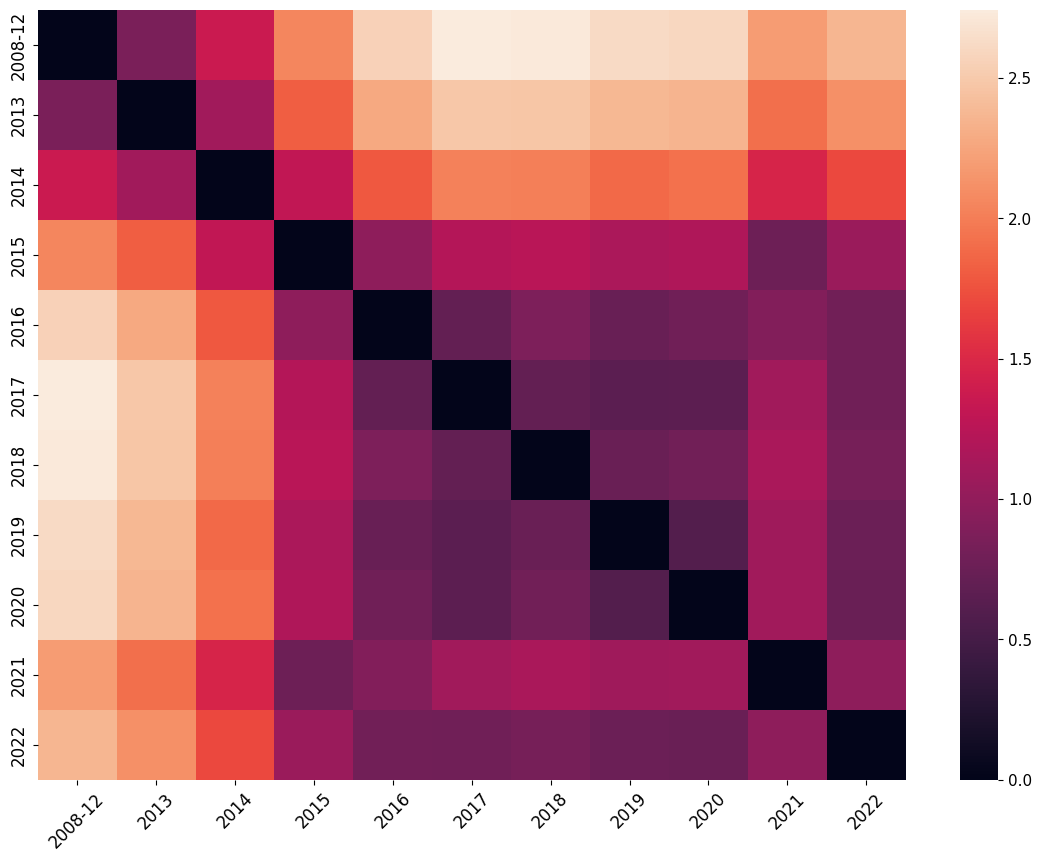

Heatmap of Dissimilarity Distances (Betweenness Centrality)


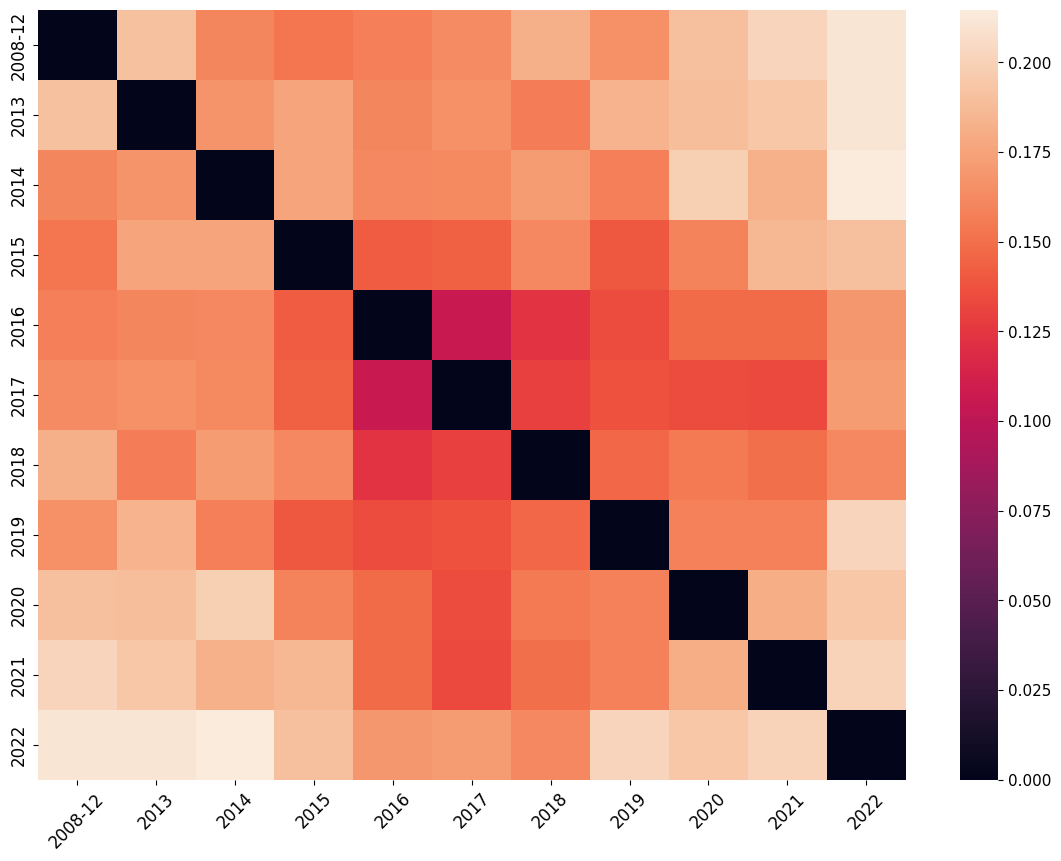

Heatmap of Dissimilarity Distances (Jaccard)


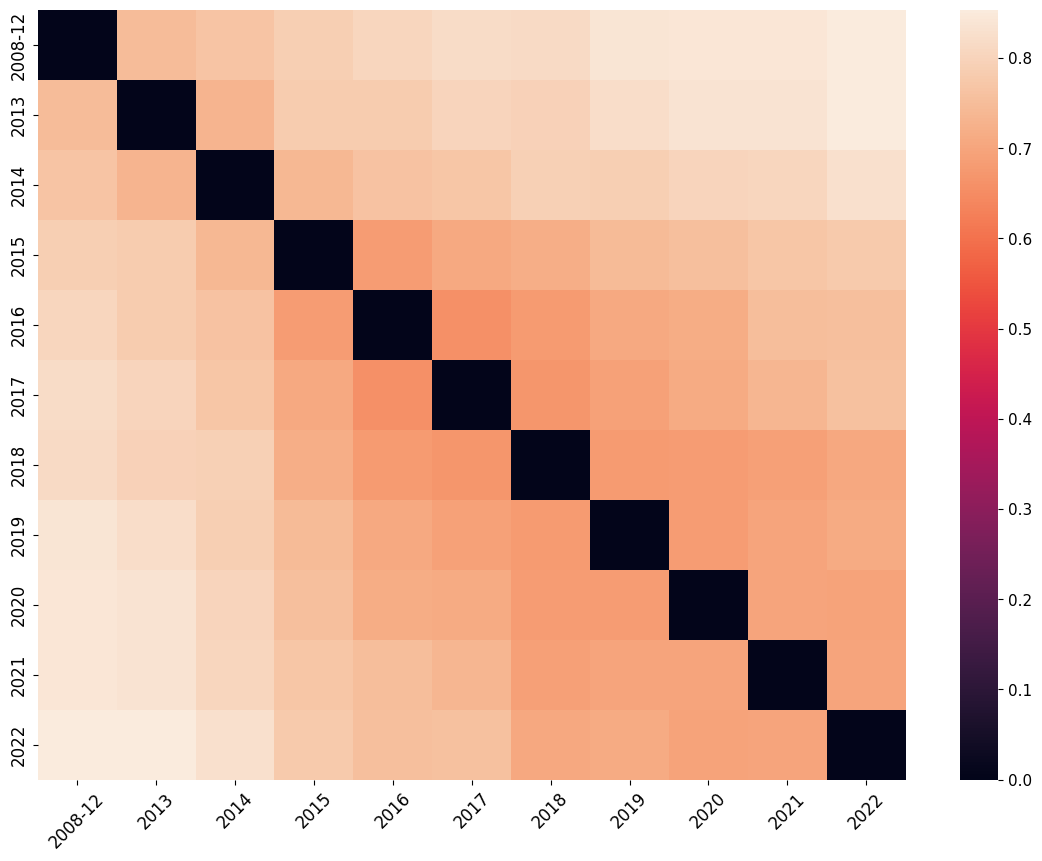

Heatmap of Dissimilarity Distances (Hamming)


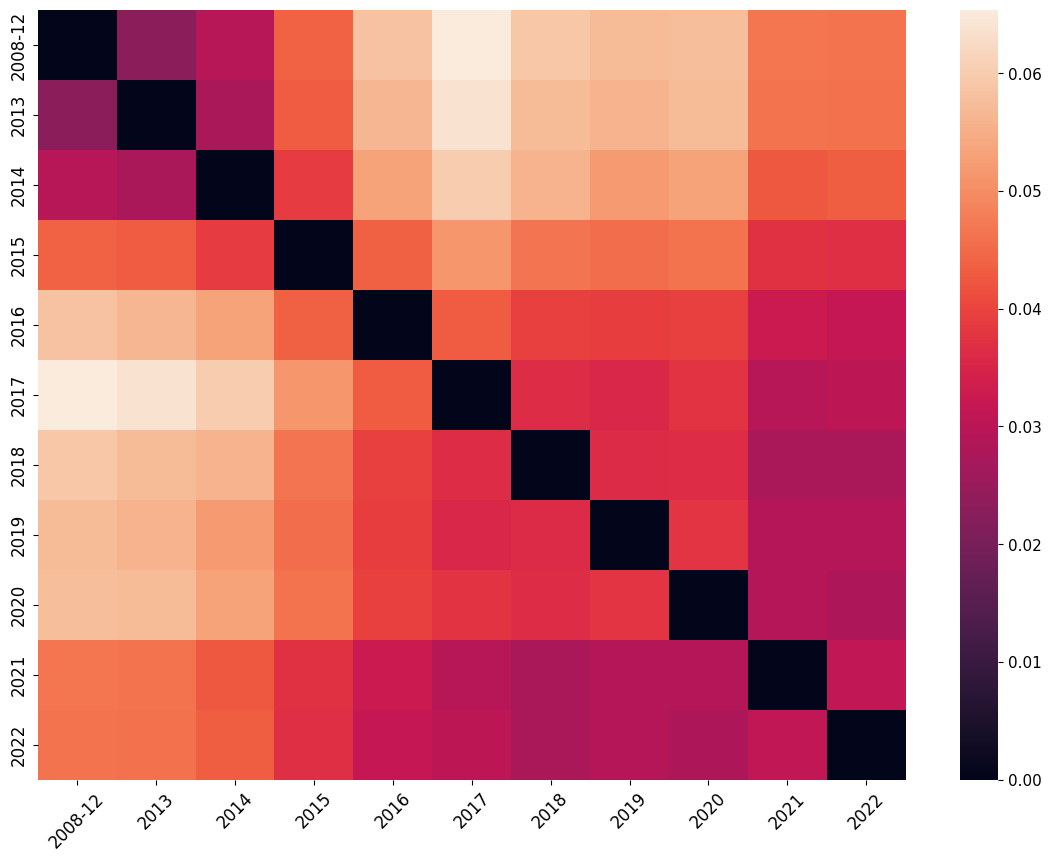

In [119]:
years = ['2008-12', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022']

D = dissimilarity_matrix(years, type='degree')
D_df = pd.DataFrame(D, columns=years).T
D_df.columns = years
sns.heatmap(D_df)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
title = 'Heatmap of Dissimilarity Distances (Degree Centrality)'
print(title)
plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
#plt.title(title)
plt.show()

D = dissimilarity_matrix(years, type='closeness')
D_df = pd.DataFrame(D, columns=years).T
D_df.columns = years
sns.heatmap(D_df)
title = 'Heatmap of Dissimilarity Distances (Closeness Centrality)'
print(title)
# plt.title(title)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
plt.show()


D = dissimilarity_matrix(years, type='betweenness')
D_df = pd.DataFrame(D, columns=years).T
D_df.columns = years
sns.heatmap(D_df)
title = 'Heatmap of Dissimilarity Distances (Betweenness Centrality)'
print(title)
# plt.title(title)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
plt.show()

D = dissimilarity_matrix(years, type='jaccard')
D_df = pd.DataFrame(D, columns=years).T
D_df.columns = years
sns.heatmap(D_df)
title = 'Heatmap of Dissimilarity Distances (Jaccard)'
print(title)
# plt.title(title)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
plt.show()

D = dissimilarity_matrix(years, type='hamming')
D_df = pd.DataFrame(D, columns=years).T
D_df.columns = years
sns.heatmap(D_df)
title = 'Heatmap of Dissimilarity Distances (Hamming)'
print(title)
# plt.title(title)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
plt.show()

### 4.2 MDS Projection and Spectral Clustering

MDS Projection (Degree centrality)


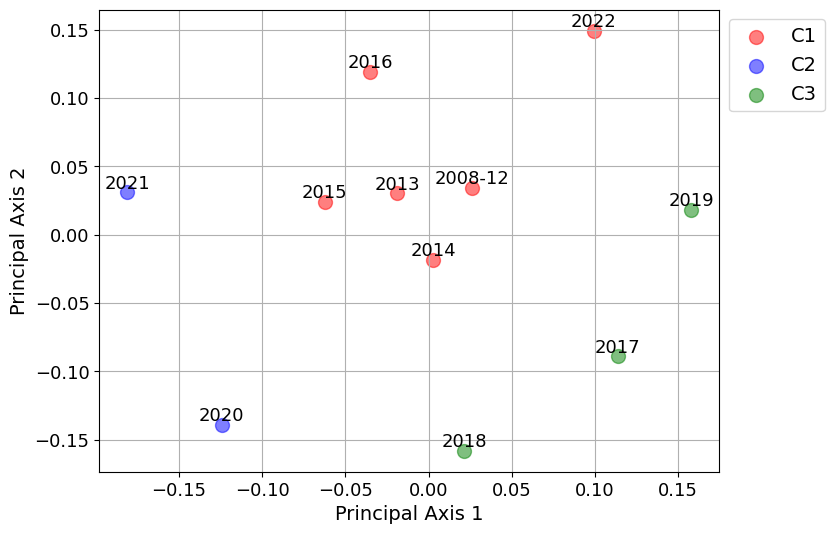

MDS Projection (Closeness centrality)


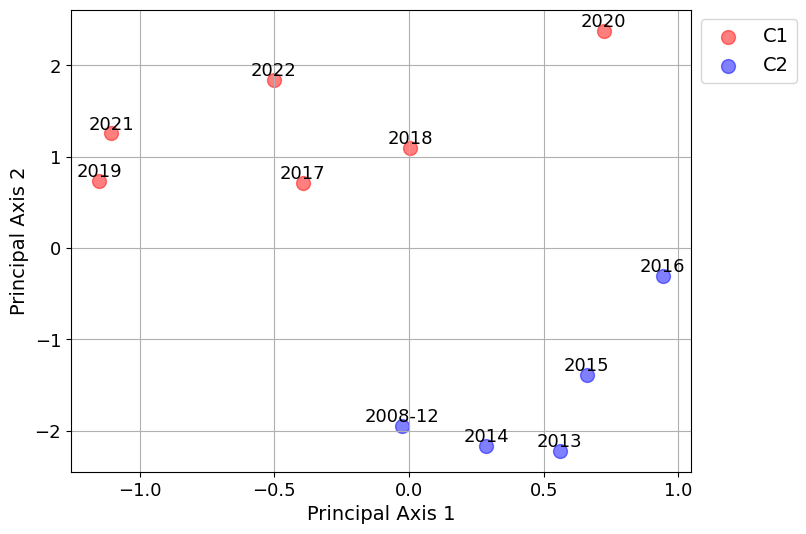

MDS Projection (Betweenness centrality)


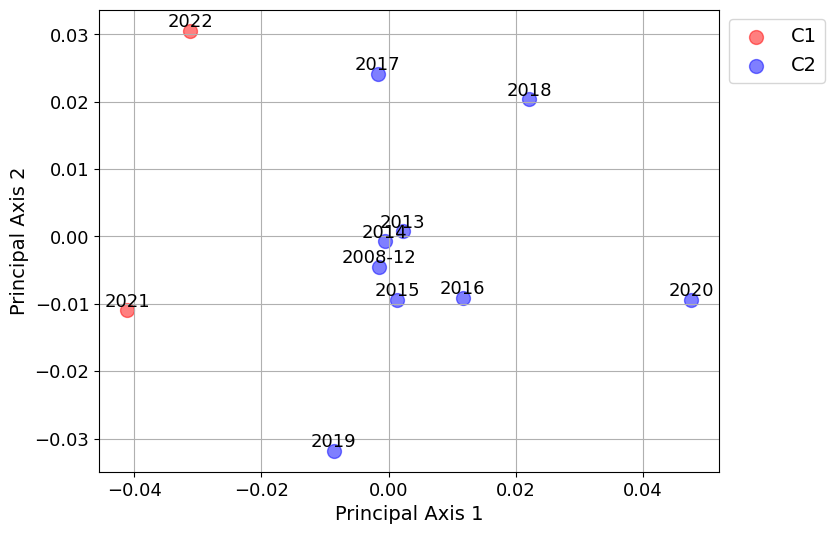

MDS Projection (Jaccard)


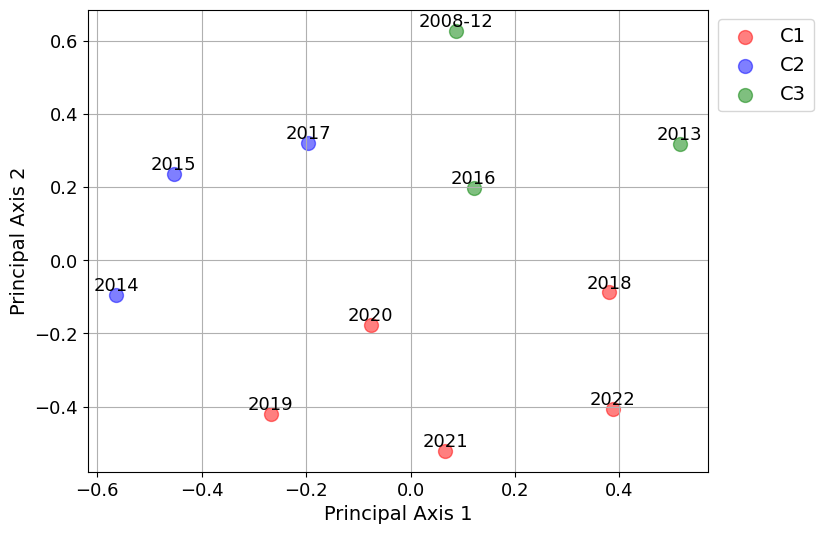

MDS Projection (Hamming)


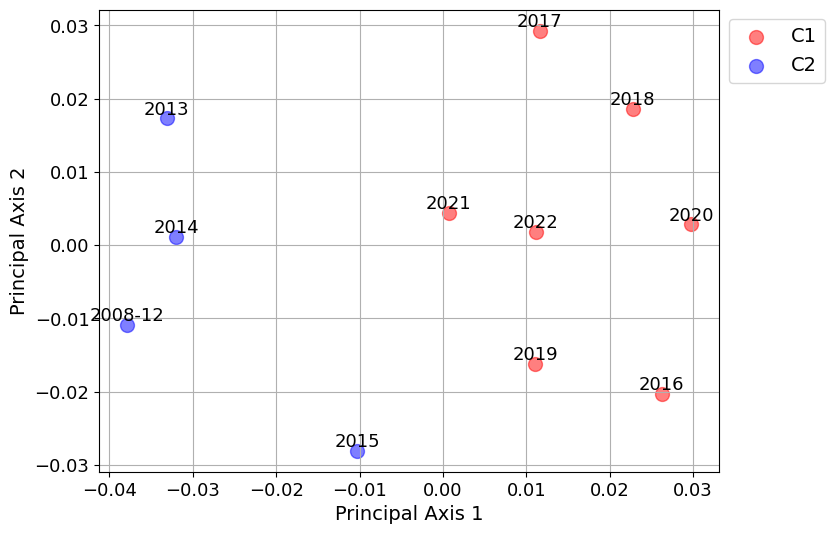

In [375]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering

years = ['2008-12', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
        '2020', '2021', '2022']

def MDS_project(D, title):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(D)
    
    n_clusters_range = range(2, 10)  
    
    best_score = -1
    best_n_clusters = 0
    
    for n_clusters in n_clusters_range:
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)
        clusters = spectral.fit_predict(mds_coords)
        
        score = silhouette_score(mds_coords, clusters)
        
        if score > best_score:
            best_score = score
            best_n_clusters = n_clusters
    
    n_clusters = best_n_clusters
    
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)
    clusters = spectral.fit_predict(mds_coords)
    
    plt.figure(figsize=(8, 6))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  # Extend this list for more clusters
    
    for i in range(n_clusters):
        plt.scatter(mds_coords[clusters == i, 0], mds_coords[clusters == i, 1], color=colors[i], alpha=0.5, label=f'C{i+1}', s=100)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    print(title)
    #plt.title(title)
    plt.xlabel('Principal Axis 1', fontsize=14)
    plt.ylabel('Principal Axis 2', fontsize=14)
    plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left', fontsize=14)
    
    for i, (x, y) in enumerate(mds_coords):
        plt.text(x, y, f'{years[i]}', fontsize=13, ha='center', va='bottom')
    
    plt.grid(True)
    plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
    plt.show()


D_degree = dissimilarity_matrix(years, type='degree')
MDS_project(D_degree, title='MDS Projection (Degree centrality)')
D_close = dissimilarity_matrix(years, type='closeness')
MDS_project(D_close, title='MDS Projection (Closeness centrality)')
D_between = dissimilarity_matrix(years, type='betweenness')
MDS_project(D_between, title='MDS Projection (Betweenness centrality)')
D_jaccard = dissimilarity_matrix(years, type='jaccard')
MDS_project(D_jaccard, title='MDS Projection (Jaccard)')
D_hamming = dissimilarity_matrix(years, type='hamming')
MDS_project(D_hamming, title='MDS Projection (Hamming)')

#### Plot consecutive distances between graphs 

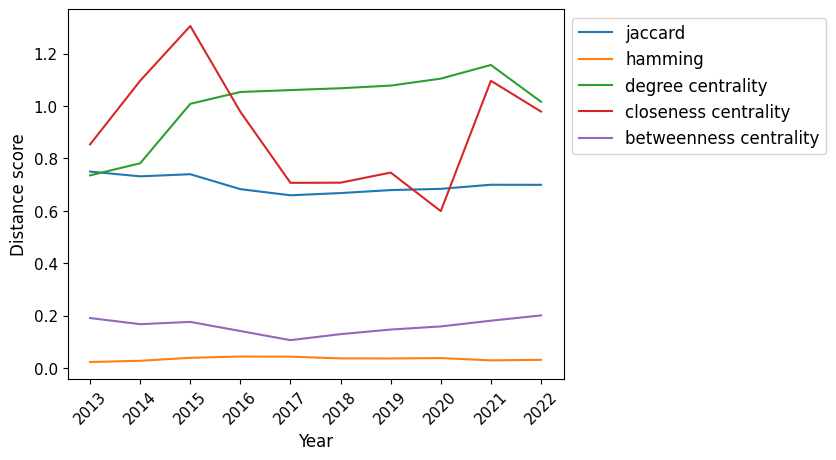

In [17]:
years = ['2008-12', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
         '2020', '2021', '2022']

D = dissimilarity_matrix(years, type='degree')
degree_lst = [ D[j-1][j] for j in range(1, len(years)) ]
D = dissimilarity_matrix(years, type='closeness')
close_lst = [ D[j-1][j] for j in range(1, len(years)) ]
D = dissimilarity_matrix(years, type='betweenness')
between_lst = [ D[j-1][j] for j in range(1, len(years)) ]
D = dissimilarity_matrix(years, type='jaccard')
jaccard_lst = [ D[j-1][j] for j in range(1, len(years)) ]
D = dissimilarity_matrix(years, type='hamming')
hamming_lst = [ D[j-1][j] for j in range(1, len(years)) ]

plt.plot(years[1:], jaccard_lst, label="jaccard")
plt.plot(years[1:], hamming_lst, label="hamming")
plt.plot(years[1:], degree_lst, label="degree centrality")
plt.plot(years[1:], close_lst, label="closeness centrality")
plt.plot(years[1:], between_lst, label="betweenness centrality")
plt.xticks(rotation=45)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Distance score', fontsize=12)
#plt.title('Plot of Consecutive Distance Scores between Temporal Networks')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left', fontsize=12)
plt.savefig(figs_dir +"{}.png".format('Plot of Consecutive Distance Scores between Temporal Networks'), bbox_inches='tight')
plt.show()

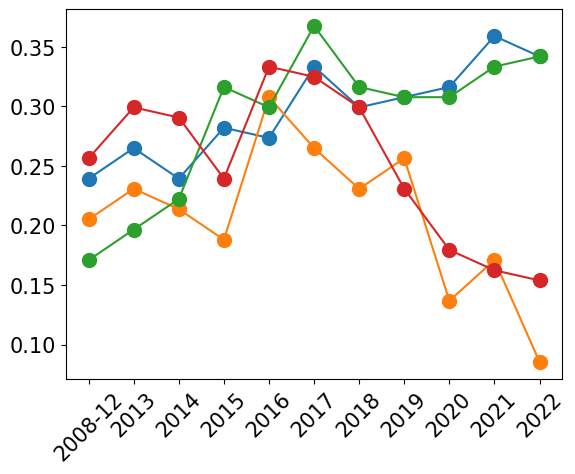

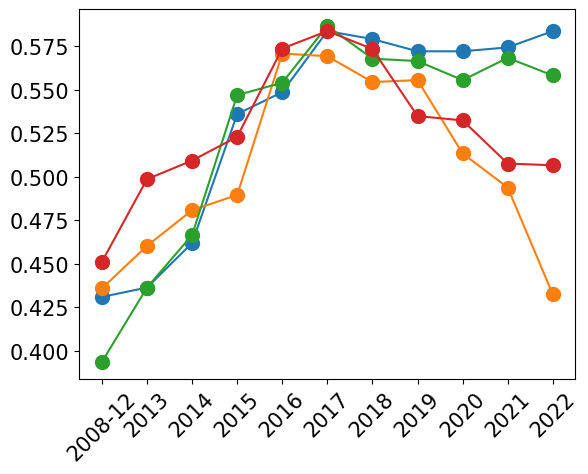

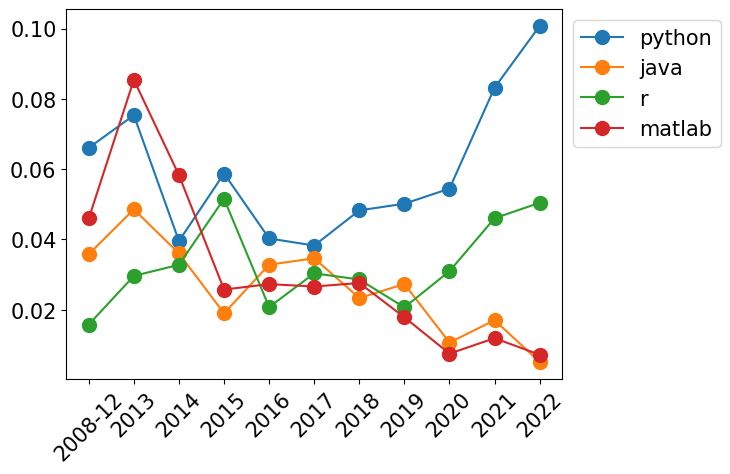

In [8]:
# Programming Languages over time
langs = ['python', 'java', 'r', 'matlab']
years = ['2008-12', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
         '2020', '2021', '2022']

temp_d = {}
temp_c = {}
temp_b = {}

for yr in years:
    temp_d[yr] = [ Degree[yr]['python'], Degree[yr]['java'], Degree[yr]['r'], Degree[yr]['matlab'] ]
    temp_c[yr] = [ Close[yr]['python'], Close[yr]['java'], Close[yr]['r'], Close[yr]['matlab'] ]
    temp_b[yr] = [ Between[yr]['python'], Between[yr]['java'], Between[yr]['r'], Between[yr]['matlab'] ]

lst = [temp_d, temp_c, temp_b]
titles = ['Degree Centrality of Programming Languages over Time', 
         'Closeness Centrality of Programming Languages over Time',
         'Betweenness Centrality of Programming Languages over Time']

for i in range(len(lst)):
    D = pd.DataFrame.from_dict(lst[i], orient='index').reset_index()
    title = titles[i]
    
    D.columns = ['year', 'python', 'java', 'r', 'matlab']
    plt.plot(D['year'], D['python'], label='python', marker='o', markersize=10)
    plt.plot(D['year'], D['java'], label='java', marker='o', markersize=10)
    plt.plot(D['year'], D['r'], label='r', marker='o', markersize=10)
    plt.plot(D['year'], D['matlab'], label='matlab', marker='o', markersize=10)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15, rotation=45)
    plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left', fontsize=15)
    plt.savefig(figs_dir +"{}.png".format(title), bbox_inches='tight')
    plt.show()

In [ ]:
# Combine a all graphs
for year in years:
    with open('graph_{}.pkl'.format(year), 'rb') as f:
        g = pickle.load(f)

    if 'machine-learning' in g:
        g.remove_node('machine-learning')
    
    for tag in most_common_tags['Tags']:
        if tag not in list(g.nodes()):
            g.add_node(tag) 

    if g.number_of_nodes() != 3916:
        print(g)
        
    G[str(year)] = g

with open('Graphs_full.pkl', 'wb') as f:
    pickle.dump(G, f)

In [126]:
%%file summative_profile.py
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os, json, pickle
from line_profiler import profile as profile
import swifter

data_dir = os.getcwd() + "/overflow_data/"

# Load and combine all JSON files into a single dataframe

years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

records = []

for year in years: 
    with open(data_dir+'overflow_{}.json'.format(year), 'r') as file:
        data = json.load(file)
    
    for item in data:
        record = item['f0_']
        
        records.append({
            'ID': record['_field_1'],
            'Timestamp': record['_field_2'],
            'Tags': record['_field_3'].lower().split('|'),  # Split the tags into a list
            'Year': year
        })
    
    # Convert the list of dictionaries to a Pandas DataFrame

df = pd.DataFrame(records)
    
# Convert the 'Timestamp' column to a datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp']) 

@profile
def compute_lift(tag1, tag2, df):
    '''
    Given Stack Overflow tags 1, 2 and a dataframe, compute the association rule learning lift
    value using co-occurrence probabilities of the tags (see Methods section of the paper)
    '''
    N = df.shape[0]
    temp = df[df['Tags'].swifter.apply(lambda x: tag1 in x or tag2 in x)]

    P_tag1 = temp[temp['Tags'].swifter.apply(lambda x: tag1 in x)].shape[0] / N
    P_tag2 = temp[temp['Tags'].swifter.apply(lambda x: tag2 in x)].shape[0] / N
    P_tag1_tag2 =  temp[temp['Tags'].swifter.apply(lambda x: tag1 in x and tag2 in x)].shape[0] / N

    lift = P_tag1_tag2 / (P_tag1 * P_tag2)

    return lift

@profile    
def construct_network_by_year(df, year):
    data = df[df['Year'] == year]
    tags = np.unique([ x for lst in data['Tags'].to_numpy() for x in lst ])
    
    g = nx.Graph()
    edges = {}

    for tag1 in tags: 
        for tag2 in tags:
            if tag1 != tag2:
                lift = compute_lift(tag1, tag2, data) 
                
                if lift > 1:
                    edges[(tag1, tag2)] = lift

    g.add_edges_from(edges.keys())

    for edge in edges:
        g.edges[edge]['weight'] = edges[edge]

    return g

def main():
    g = construct_network_by_year(df, 2008)
    degrees = dict(g.degree())
    nx.set_node_attributes(g, name='degree', values=degrees)
    
    # The node size will be proportional to its degree, adjusted for visualization
    node_sizes = [v * 100 for v in degrees.values()]
    
    pos = nx.spring_layout(g)

# # Draw the network
# plt.figure(figsize=(10, 8))
# nx.draw_networkx(g, pos=pos, node_size=node_sizes, with_labels=False, node_color='skyblue', alpha=1, edge_color='black')
# plt.axis('off')  # Turn off the axis
# plt.show()

if __name__=='__main__':
    #Run the main function
    main()

Overwriting summative_profile.py


In [ ]:
!python summative_profile.py

In [ ]:
!kernprof -l summative_profile.py

In [129]:
!python -m line_profiler summative_profile.py.lprof

Timer unit: 1e-06 s

Total time: 2.01634 s
File: summative_profile.py
Function: compute_lift at line 38

Line #      Hits         Time  Per Hit   % Time  Line Contents
    38                                           @profile
    39                                           def compute_lift(tag1, tag2, df):
    40                                               '''
    41                                               Given Stack Overflow tags 1, 2 and a dataframe, compute the association rule learning lift
    42                                               value using co-occurrence probabilities of the tags (see Methods section of the paper)
    43                                               '''
    44       306        408.0      1.3      0.0      N = df.shape[0]
    45       306     507487.0   1658.5     25.2      temp = df[df['Tags'].swifter.apply(lambda x: tag1 in x or tag2 in x)]
    46                                           
    47       306     526105.0   1719.3     26.1    